# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

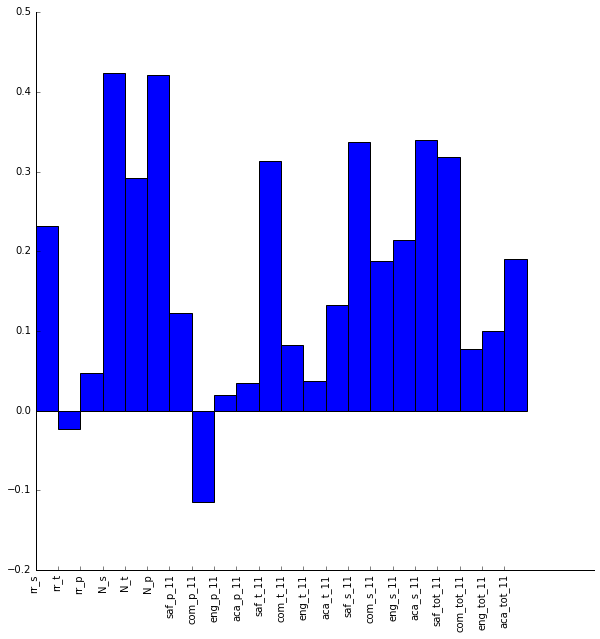

In [11]:
survey_fields
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(10,10))
x = np.arange(len(survey_fields)) 
ax.bar(x,correlations[survey_fields],width=1)
ax.set_xticks(x)

ax.tick_params(top='off',right='off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_position('zero')
ax.set_xticklabels(survey_fields,rotation=90)

plt.show()
    

Markdown cell

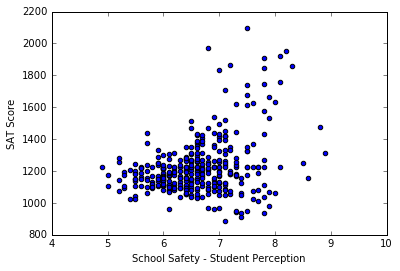

In [12]:
plt.scatter(combined['saf_s_11'],combined['sat_score'])
plt.xlabel('School Safety - Student Perception')
plt.ylabel('SAT Score')
plt.show()

Scatter plot seems to be linear but the sample variance is high

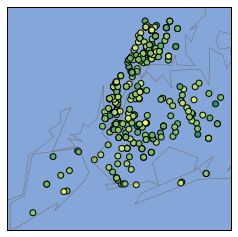

In [13]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
    )
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

grouped = combined.groupby('DBN')
avg_data = grouped.agg(np.mean).reset_index()
#avg_data['saf_tot_11']

m.scatter(x = avg_data['lon'].tolist(),y=avg_data['lat'].tolist(),latlon=True, c=avg_data['saf_tot_11'], cmap='summer',s=35)


Manhattan and Queens has lower safety scored compared to schools in Brooklyn.

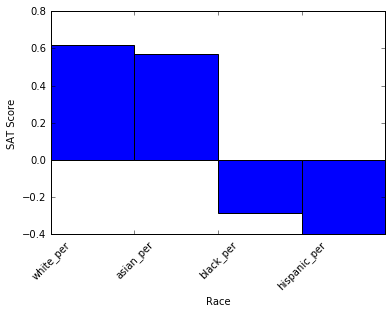

In [14]:
cols = ['white_per','asian_per', 'black_per', 'hispanic_per']
x = np.arange(4)
fig, ax = plt.subplots()
ax.bar(x,correlations[cols],width=1)
ax.set_xticks(x)
ax.set_xticklabels(cols,rotation=45)
plt.xlabel('Race')
plt.ylabel('SAT Score')

plt.show()

Schools with a higher percentage of white and asians perform better at SATs than schools with black and hispanic population

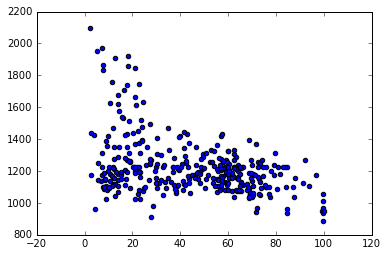

-0.39698493078147196

In [15]:
plt.scatter(combined['hispanic_per'],combined['sat_score'])
plt.show()
correlations['hispanic_per']

In [17]:
combined['school_name'][combined['hispanic_per'] >95]


44                         Manhattan Bridges High School
82      Washington Heights Expeditionary Learning School
89     Gregorio Luperon High School for Science and M...
125                  Academy for Language and Technology
141                International School for Liberal Arts
176     Pan American International High School at Monroe
253                            Multicultural High School
286               Pan American International High School
Name: school_name, dtype: object

In [18]:
combined['school_name'][combined['hispanic_per'] < 10]


37                                Stuyvesant High School
46       High School for Dual Language and Asian Studies
151                         Bronx High School of Science
187                       Brooklyn Technical High School
192                          Bedford Academy High School
194                            Benjamin Banneker Academy
220                           Boys and Girls High School
223    Academy for College Preparation and Career Exp...
226               The High School for Global Citizenship
227                         School for Human Rights, The
228                  School for Democracy and Leadership
229    High School for Youth and Community Developmen...
230        High School for Service & Learning at Erasmus
231    Science, Technology and Research Early College...
235              Medgar Evers College Preparatory School
236                             Clara Barton High School
237                           It Takes a Village Academy
238                           B

hispanic_per > 95 - more immigrants
hispanic_per <10 - magnet schools

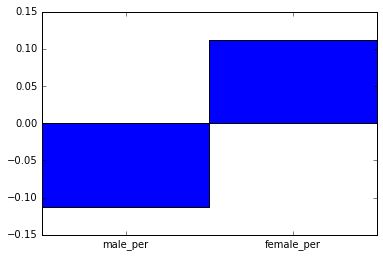

In [26]:
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(2)
cols = ['male_per', 'female_per']
fig, ax = plt.subplots()
ax.bar(x, correlations[cols], width=1)
ax.set_xticks(x+0.5)
ax.set_xticklabels(cols)
plt.show()

Negative correlation between male_per and sat scores
Positive correlation between female_per and sat scores

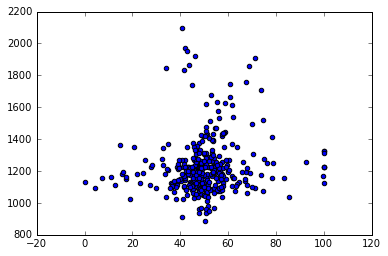

In [27]:
fig, ax = plt.subplots()
ax.scatter(combined['female_per'],combined['sat_score'],s=20)


Not a strong correlation(?)

In [28]:
combined['school_name'][(combined['female_per'] > 60) & (combined['sat_score']>1700)]


5                         Bard High School Early College
26                         Eleanor Roosevelt High School
60                                    Beacon High School
61     Fiorello H. LaGuardia High School of Music & A...
302                          Townsend Harris High School
Name: school_name, dtype: object

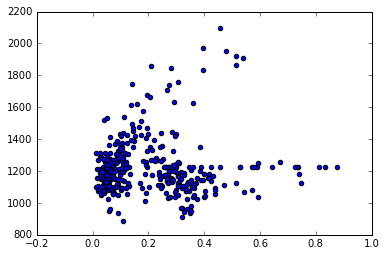

In [29]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
plt.scatter(combined['ap_per'],combined['sat_score'])


No strong correlation between percentage of AP test takers and SAT score